In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 

import matplotlib.pyplot as plt #pip install matplotlib

import numpy as np
import math, os, random
from einops import rearrange #pip install einops
from typing import List

from pathlib import Path
from PIL import Image

!pip install astropy
from astropy.io import fits 

from tqdm.notebook import tqdm #pip install tqdm

# Diffusion models for Galaxy images generation

## Model design
Code source from <a href="https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946" target="_blank">Diffusion Model from Scratch in Pytorch</a> 

### UNET model
For our diffusion model we consider a architecture based on the <a href="https://arxiv.org/pdf/1505.04597" target="_blank"> UNET</a> model.

"The main idea is to supplement a usual contracting network by successive layers, where pooling operators are replaced by upsampling operators. Hence, these layers increase the resolution of the output. In order to localize, high resolution features from the contracting path are combined with the upsampled output. A successive convolution layer can then learn to assemble a more precise output based on this information"

*from "U-Net: Convolutional Networks for Biomedical Image Segmentation" (https://arxiv.org/pdf/1505.04597)*

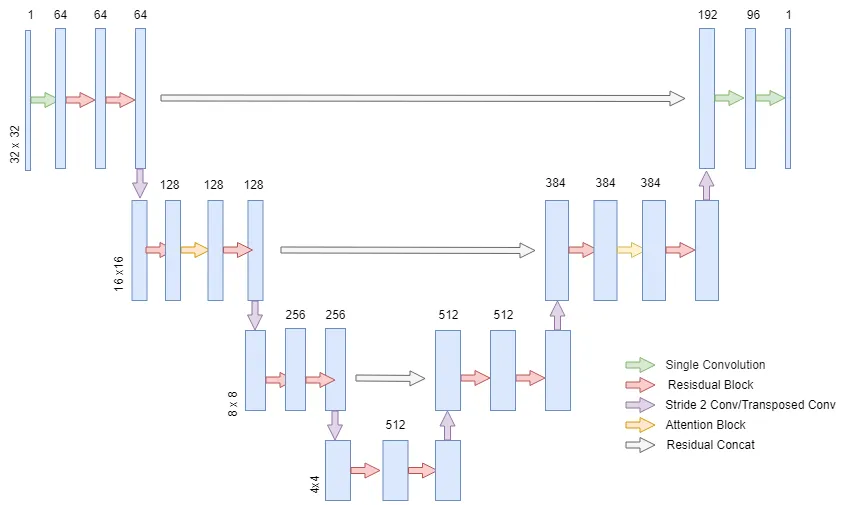

*by Nicholas DiSalvo in* <a href="https://towardsdatascience.com/diffusion-model-from-scratch-in-pytorch-ddpm-9d9760528946" target="_blank">*Diffusion Model from Scratch in Pytorch*</a> 

The U-net is composed of residual convolutional layers either downscaling or upscaling the input data.\
Let's have a closer look at a U-net layer:

### Unet Layer

In [5]:
class UnetLayer(nn.Module):
    def __init__(self, 
            upscale: bool, 
            attention: bool, 
            num_groups: int, 
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

Each U-net layer is composed of two <font color="red">Residual Blocks</font> and a <font color="purple">Convolutional layer</font>.\
Optionally, an <font color="gold">Attention layer</font> can be turned on within the two residuals blocks.\
(color code according to the arrows in the schematic).

### Residual Block

In [3]:
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

### Attention Layer

In [4]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

### Sinusoidal Embedding

In [2]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

### UNET model

In [6]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

### Scheduler

In [7]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

### Utils

In [8]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def npy_loader(path, input_dim=32):
    sample = torch.from_numpy(np.load(path))
    sample = sample[:, None, :, :]
    #sample = transforms.Resize(size=(28, 28), max_size=None)(sample)
    sample = transforms.CenterCrop(input_dim)(sample)
    return sample

_________________
## Loading dataset

In [2]:
# We'll download the data from drive first
!pip install gdown
!gdown --id 1Vv2AsiKDfG0Io1iYw7qlvgiR05WJBXz-

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Vv2AsiKDfG0Io1iYw7qlvgiR05WJBXz-
From (redirected): https://drive.google.com/uc?id=1Vv2AsiKDfG0Io1iYw7qlvgiR05WJBXz-&confirm=t&uuid=6b13147f-bac1-4771-9447-2f8a54d0944c
To: /home/sagemaker-user/cosmos_128.npy
100%|████████████████████████████████████████| 407M/407M [00:07<00:00, 52.6MB/s]


In [14]:
x = np.load('galaxy/cosmos_128.npy')
n_pixels = (x.shape[1], x.shape[2])
print('Number of events: ', x.shape[0])
print("Image size: ", n_pixels)

Number of events:  6210
Image size:  (128, 128)


#### visualize training data
when working on a dataset for the first time, it is always useful to plot a subset of the training points and obeserve the relevant properties of the dataset. In the following we plot the marginals of the training data distribution. From the plots it becomes evident a peculiar feature of this dataset, often referred to as *zero padding*, namely the practice of filling with zeros the entries corresponding to specific objects that are not observed in the event.

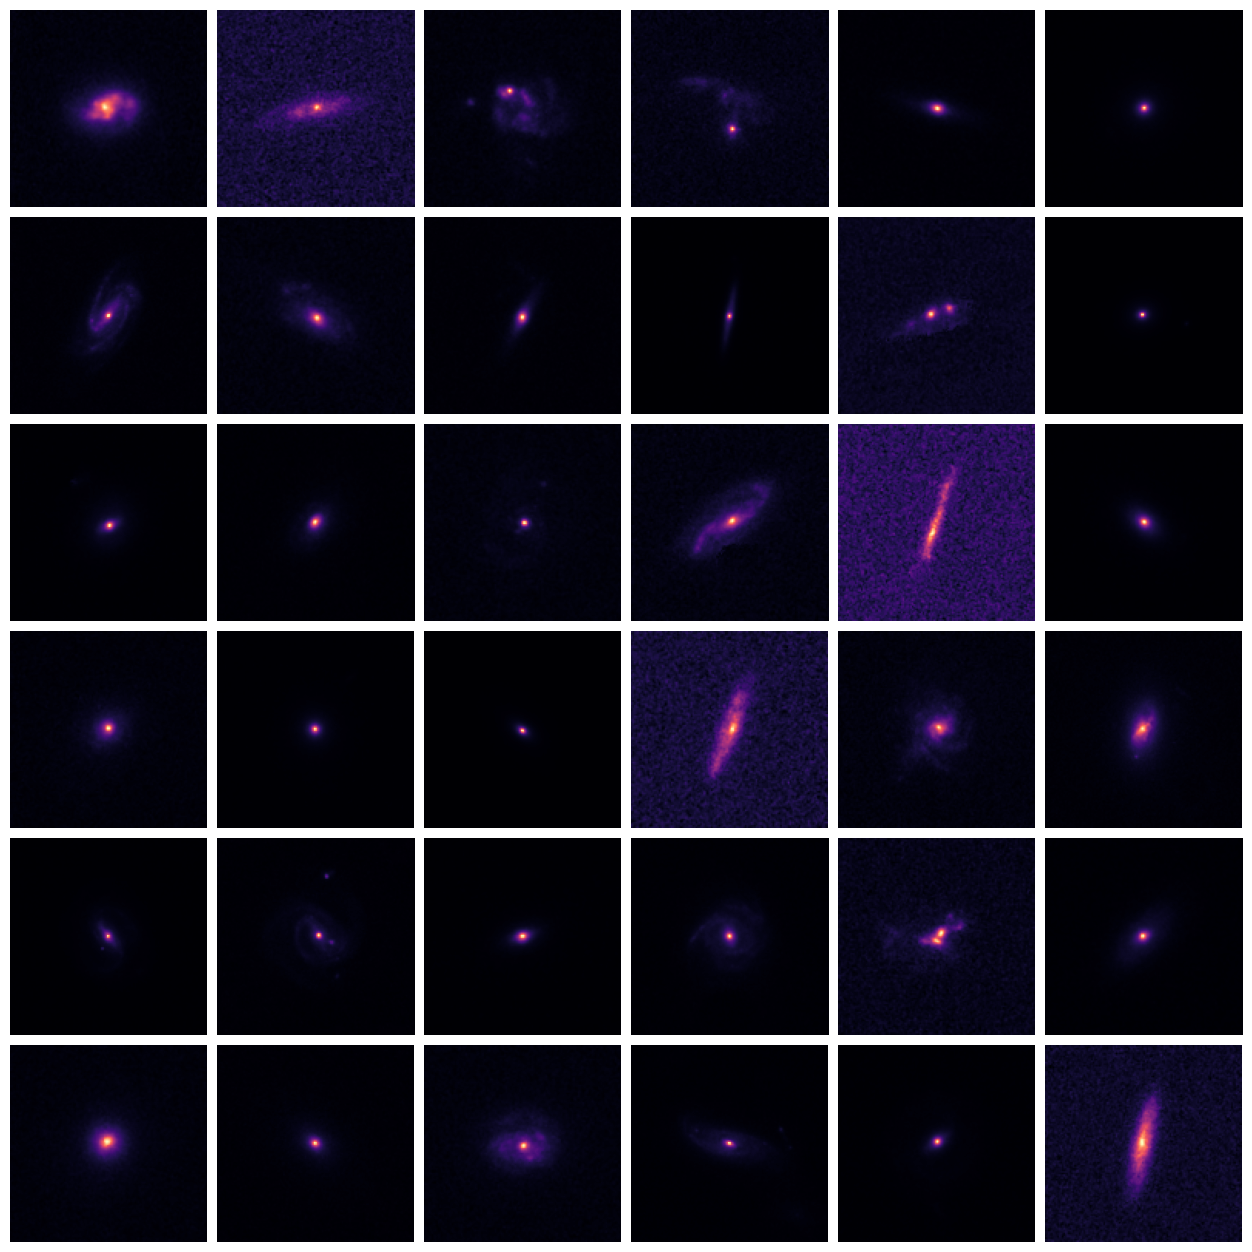

In [11]:
# Let's look at some data examples, you should see some clean galaxy images.
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 6),axes_pad=0.1,)
for ax, im in zip(grid, x[np.random.randint(len(x), size=36)]):
    ax.imshow(im, cmap='magma')
    ax.axis('off')
plt.show()

## Training routine

In [9]:
def train(
    data_path: str='./galaxy/cosmos_128.npy', batch_size: int=16, num_time_steps: int=1000, num_epochs: int=15, 
    seed: int=-1, ema_decay: float=0.9999,  lr=2e-5, checkpoint_path: str=None,input_dim: int=32,
    unet_Channels: List=[64, 128, 256, 512, 512, 384],
    unet_Attentions: List = [False, True, False, False, False, True],
    unet_Upscales: List = [False, False, False, True, True, True],
    unet_num_groups: List = 32,
    unet_dropout_prob: List = 0.1,
    unet_num_heads: List = 8,
    unet_input_channels: List = 1,
    unet_output_channels: List = 1,
         ):
    # define data loader
    set_seed(random.randint(0, 2**32-1)) if seed == -1 else set_seed(seed)
    train_dataset = torch.utils.data.TensorDataset(npy_loader(data_path, input_dim))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
    
    # define scheduler
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    
    # define models
    model = UNET(
            unet_Channels,
            unet_Attentions,
            unet_Upscales,
            unet_num_groups,
            unet_dropout_prob,
            unet_num_heads,
            unet_input_channels,
            unet_output_channels,
    ).cuda()
    ema = ModelEmaV3(model, decay=ema_decay)
    
    # define optmizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # load checkpoint if present
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    # define loss
    criterion = nn.MSELoss(reduction='mean')

    # start the training
    for i in range(num_epochs):
        total_loss = 0
        for bidx, (x,) in enumerate(tqdm(train_loader, desc=f"Epoch {i+1}/{num_epochs}")):
            x = x.cuda()
            x = F.pad(x, (2,2,2,2))
            t = torch.randint(0,num_time_steps,(batch_size,))
            e = torch.randn_like(x, requires_grad=False)
            a = scheduler.alpha[t].view(batch_size,1,1,1).cuda()
            x = (torch.sqrt(a)*x) + (torch.sqrt(1-a)*e)
            output = model(x, t)
            optimizer.zero_grad()
            loss = criterion(output, e)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            ema.update(model)
        print(f'Epoch {i+1} | Loss {total_loss / (60000/batch_size):.5f}')
        torch.cuda.empty_cache()
        
        # save model at the end of each epoch
        checkpoint = {
            'weights': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'ema': ema.state_dict()
        }
        torch.save(checkpoint, checkpoint_path)

In [13]:
train(
        data_path='./galaxy/cosmos_128.npy',
        batch_size=32,
        num_time_steps=1000,
        num_epochs=2,
        seed=-1,
        ema_decay=0.9999,
        lr=2e-5,
        input_dim=64,
        checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',

        unet_Channels = [128, 256, 512, 512],
        unet_Attentions = [False, True, False, True],
        unet_Upscales = [False, False, True, True],
        unet_num_groups = 16,
        unet_dropout_prob = 0.1,
        unet_num_heads = 8,
        unet_input_channels = 1,
        unet_output_channels = 1,

)

Epoch 1/2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 1 | Loss 0.00020


Epoch 2/2:   0%|          | 0/194 [00:00<?, ?it/s]

Epoch 2 | Loss 0.00019


## Generating new samples

In [10]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, 
              input_dim: int=32,
            unet_Channels: List=[64, 128, 256, 512, 512, 384], 
            unet_Attentions: List = [False, True, False, False, False, True],
            unet_Upscales: List = [False, False, False, True, True, True],
            unet_num_groups: List = 32,
            unet_dropout_prob: List = 0.1,
            unet_num_heads: List = 8,
            unet_input_channels: List = 1,
            unet_output_channels: List = 1,
             ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET(
        unet_Channels,
            unet_Attentions,
            unet_Upscales,
            unet_num_groups,
            unet_dropout_prob,
            unet_num_heads,
            unet_input_channels,
            unet_output_channels,
    ).cuda()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, input_dim, input_dim)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cuda(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, input_dim, input_dim)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cuda(),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

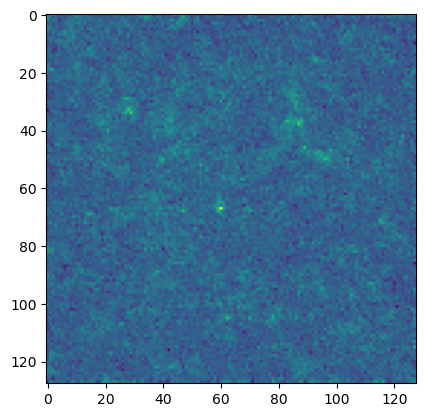

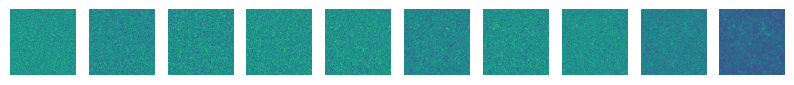

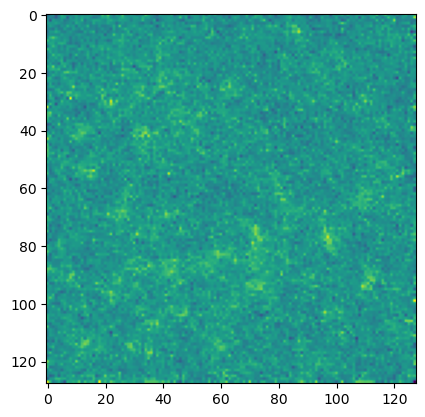

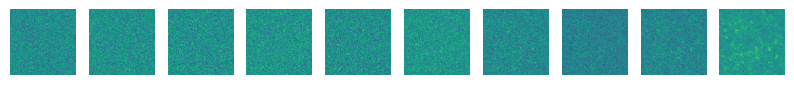

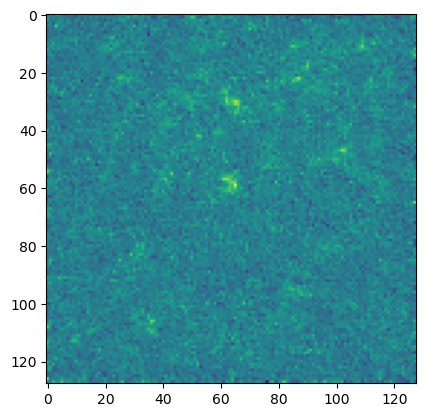

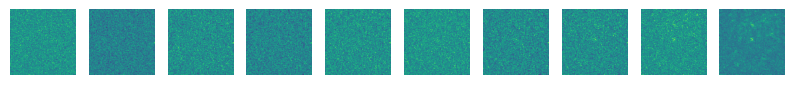

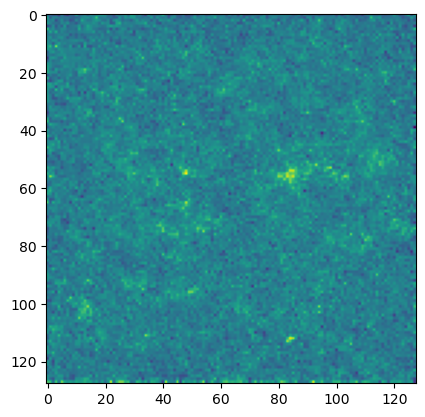

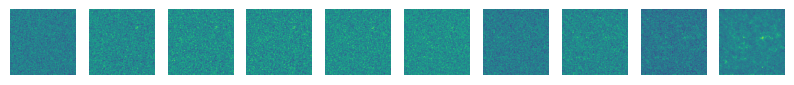

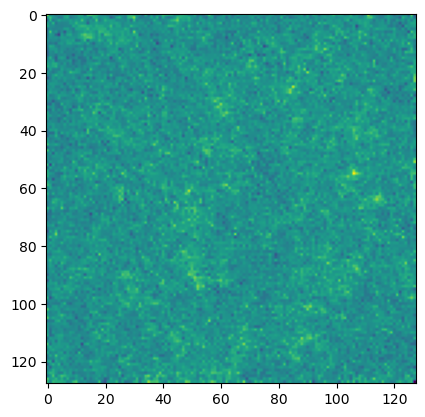

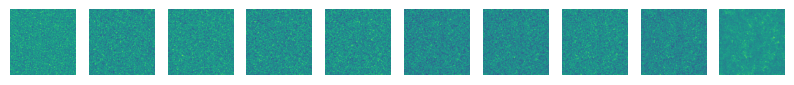

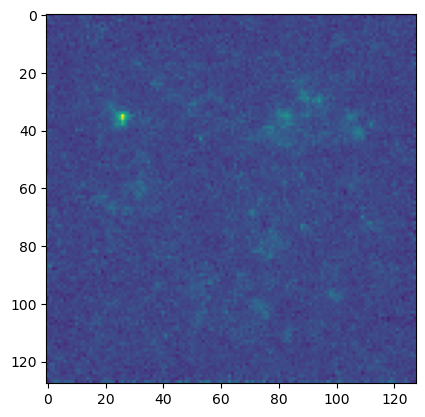

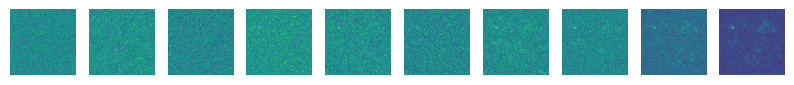

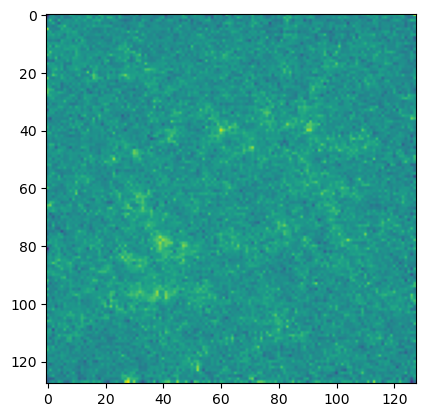

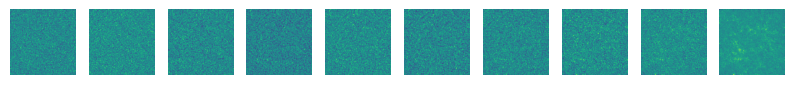

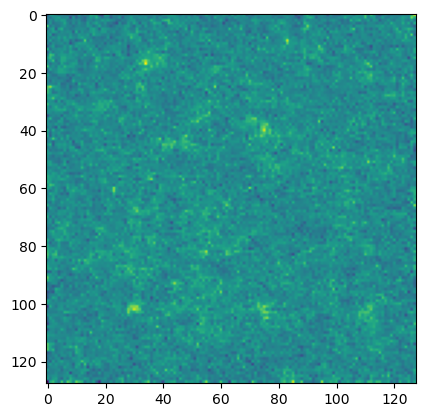

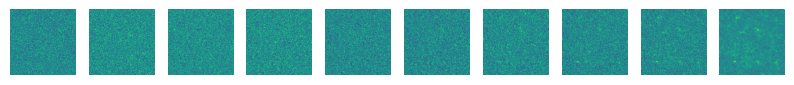

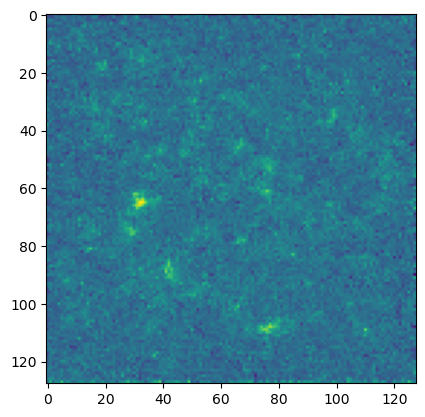

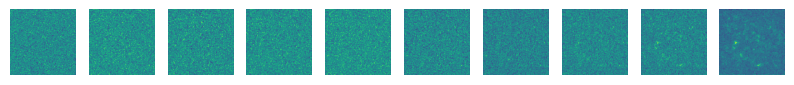

KeyboardInterrupt: 

In [28]:
#epoch 20
inference(checkpoint_path='checkpoints/ddpm_checkpoint_downsample64',
         unet_Channels = [128, 256, 512, 512],
            unet_Attentions = [False, True, False, True],
            unet_Upscales = [False, False, True, True],
            unet_num_groups = 64,
            unet_dropout_prob = 0.1,
            unet_num_heads = 8,
            unet_input_channels = 1,
            unet_output_channels = 1,
         )

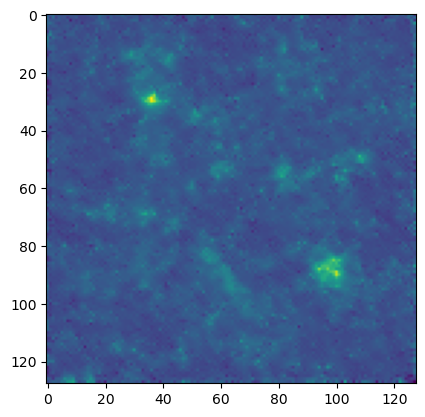

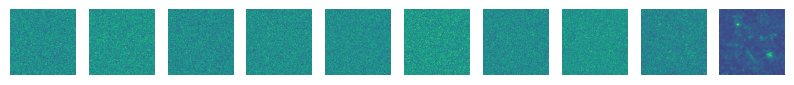

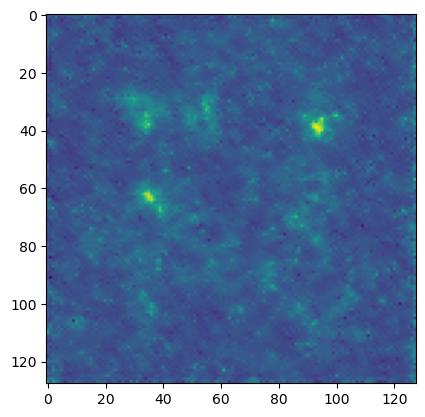

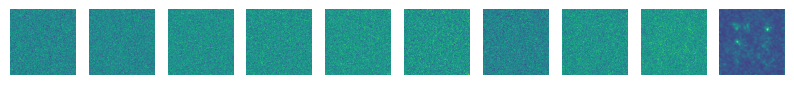

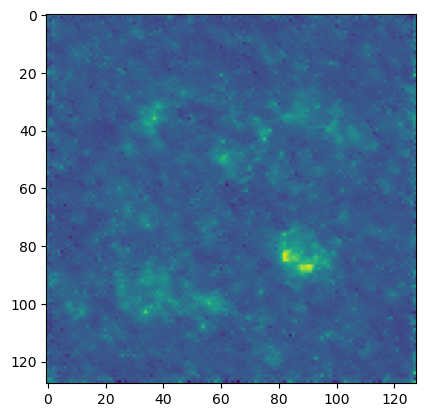

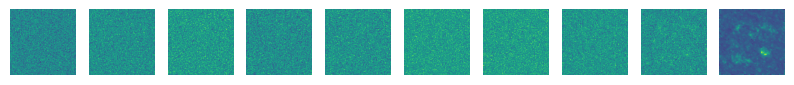

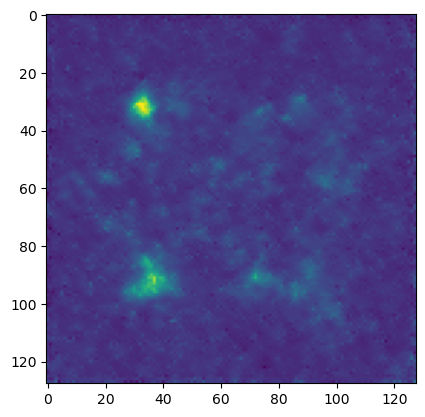

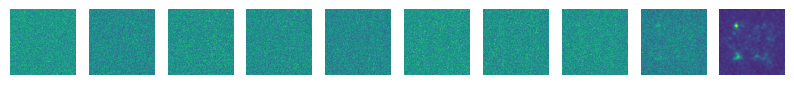

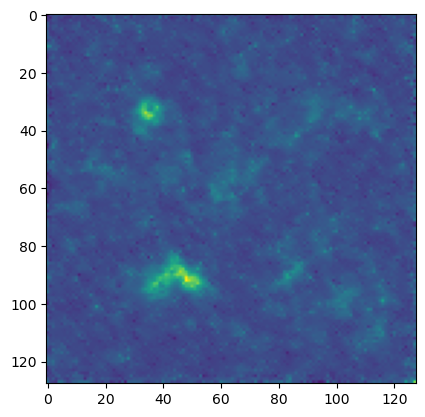

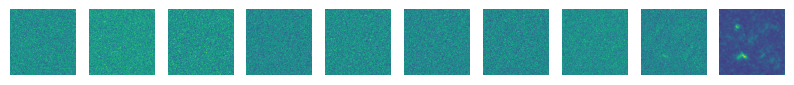

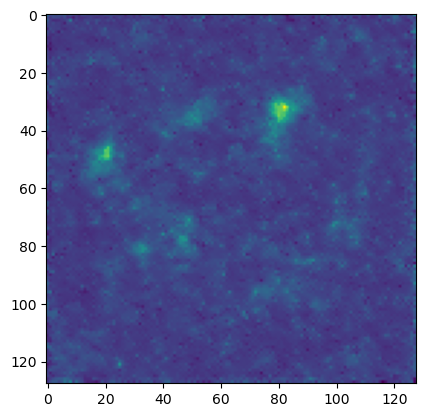

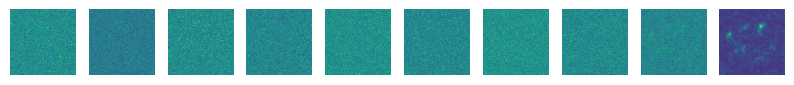

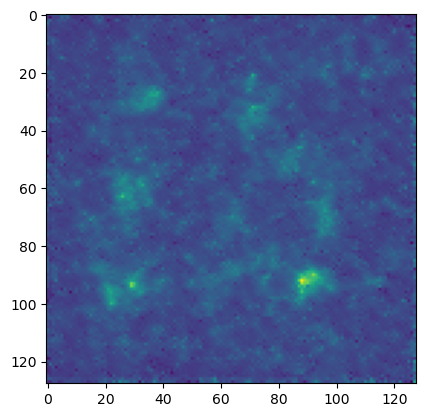

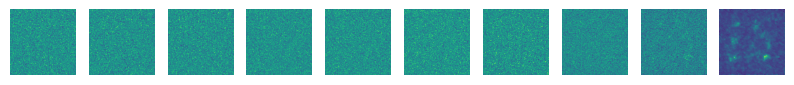

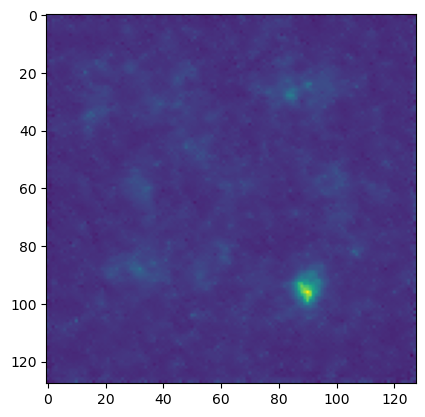

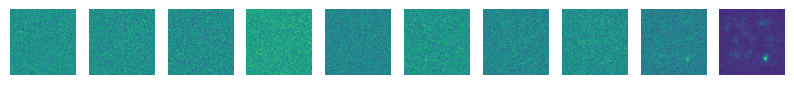

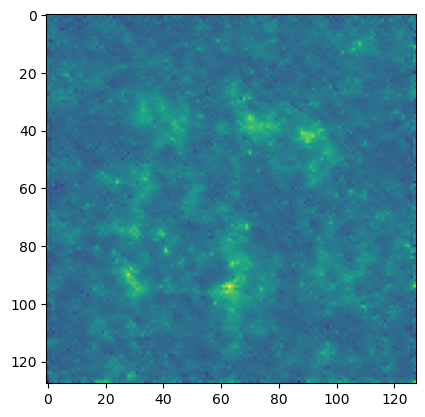

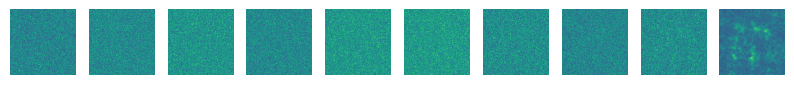

In [ ]:
#epoch 40
inference(checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
         unet_Channels = [128, 256, 512, 512],
            unet_Attentions = [False, True, False, True],
            unet_Upscales = [False, False, True, True],
            unet_num_groups = 64,
            unet_dropout_prob = 0.1,
            unet_num_heads = 8,
            unet_input_channels = 1,
            unet_output_channels = 1,
         )

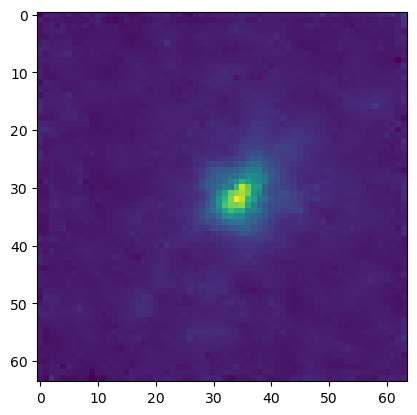

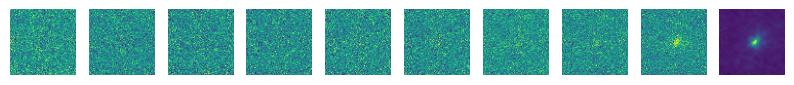

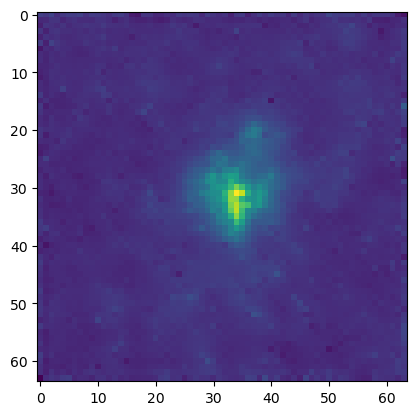

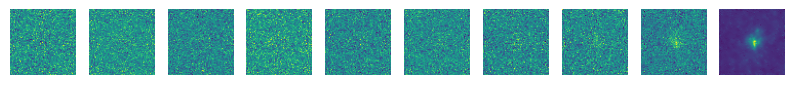

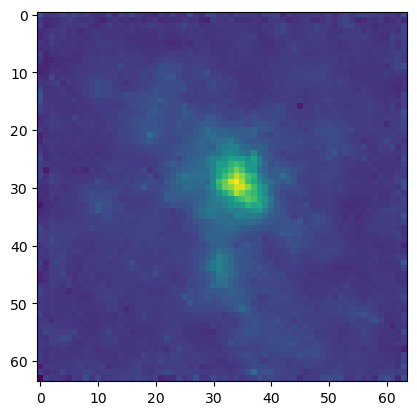

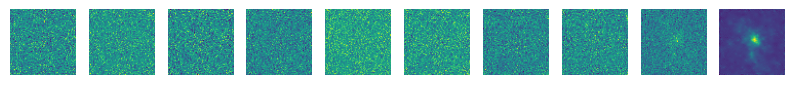

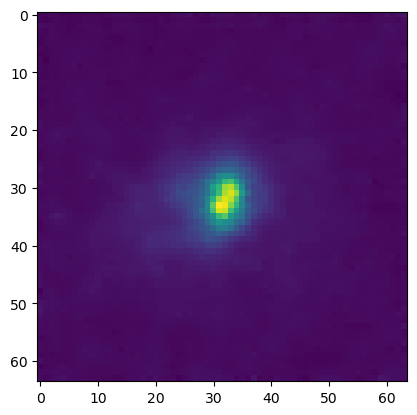

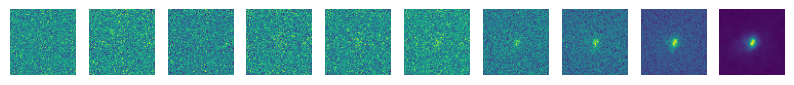

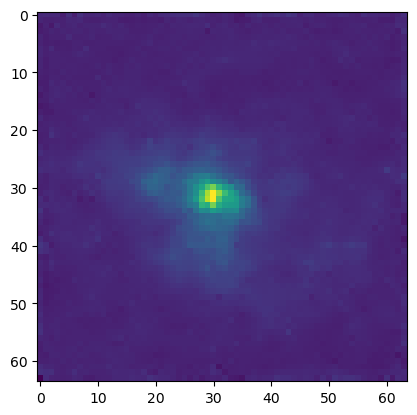

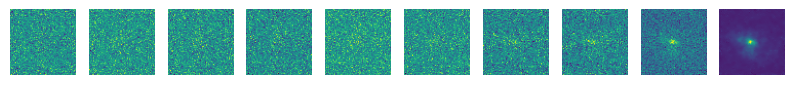

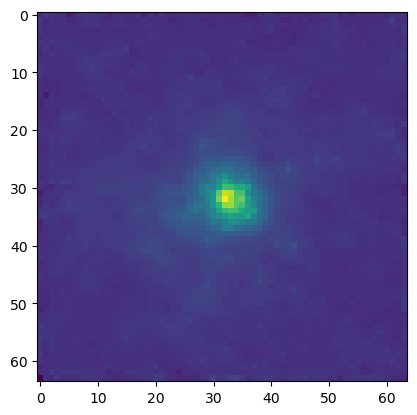

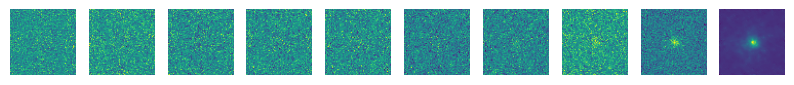

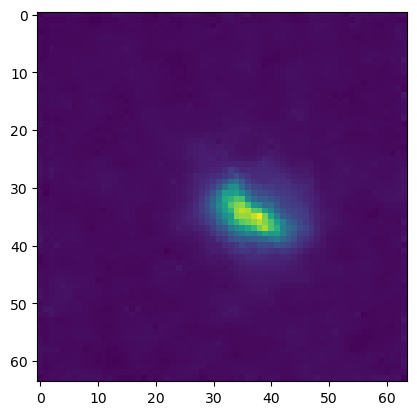

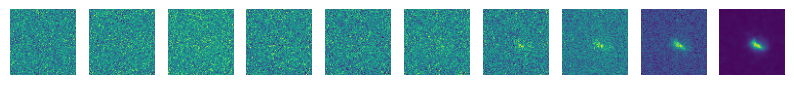

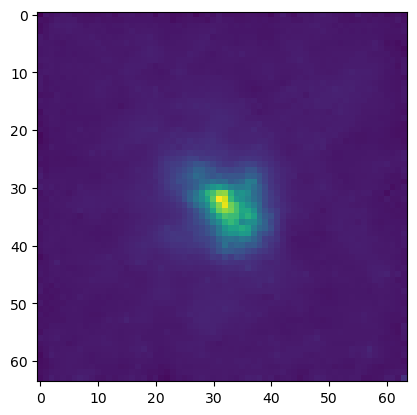

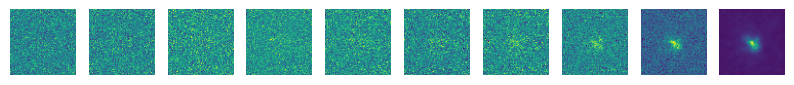

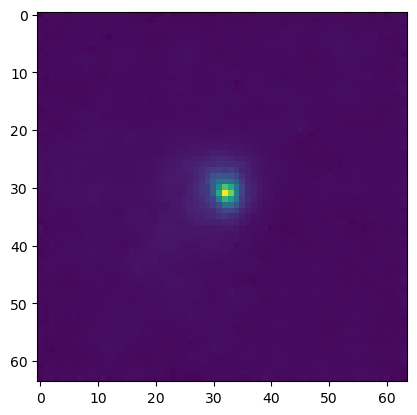

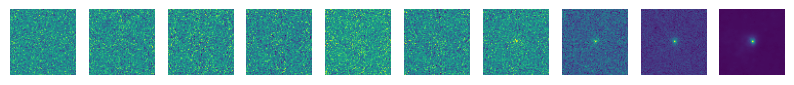

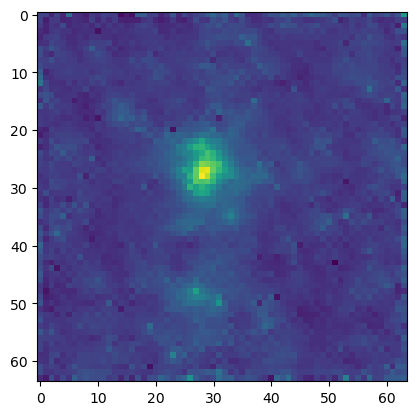

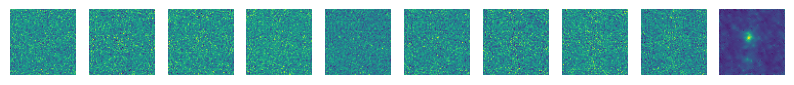

In [12]:
#epoch 80
inference(checkpoint_path='checkpoints/ddpm_checkpoint_centercrop64',
          input_dim=64,
         unet_Channels = [128, 256, 512, 512],
            unet_Attentions = [False, True, False, True],
            unet_Upscales = [False, False, True, True],
            unet_num_groups = 64,
            unet_dropout_prob = 0.1,
            unet_num_heads = 8,
            unet_input_channels = 1,
            unet_output_channels = 1,
         )

## How to quantify the goodness of a generative model??

One can perform two sample tests based on binary classifiers between the samples.

Here some literature on the topic:
- "Goodness of fit by Neyman-Pearson testing" https://scipost.org/SciPostPhys.16.5.123
- "Comparison of Affine and Rational Quadratic Spline Coupling and Autoregressive Flows through Robust Statistical Tests" https://www.mdpi.com/2073-8994/16/8/942
- "Evaluating generative models in high energy physics" https://journals.aps.org/prd/abstract/10.1103/PhysRevD.107.076017
- "A Kernel Two-Sample Test" http://jmlr.org/papers/v13/gretton12a.html
- "How to Understand Limitations of Generative Networks" https://scipost.org/submissions/2305.16774v2